# Climate Change Time Series Prediction


## Introduction
Our project aims to predict the yearly temperature changes of a given city over a given time period, using an <b>ARIMA model, LSTM</b> for <b>time series forecasting</b>.

<p>We also aim to predict the <b>top-10 cities</b> in the <b>India </b>that will experience the most temperature change in the next 10 years.</p>

<p>Aditionally, we analyze the correlation between pollution data and temperature change. We have also predicted future Greenhouse Gas emissions and analyzed the correlation with the predicted temperature.</p>

### OBJECTIVE 1: Predicting the Temperature Change of a Given City across a Specified Time Period
<p>To accomplish this, we used data from the <i><a href="https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data" target="_blank">Climate Change: Earth Surface Temperature Data</a></i> dataset on Kaggle.</p>

<b>Pre-Processing:</b><br>
<ol>
<li>Converting the 'dt' (date) column to DateTime format</li>
<li>Dropping irrelevant columns and removing rows with NaN values</li>
</ol>
<b>Processing:</b><br>
ARIMA models need the data to be stationary i.e. the data must not exhibit trend and/or seasonality. To identify and remove trend and seasonality, we used the following methods:
<ol>
<li>Plotting the time series to visually check for trend and seasonality</li>
<li>Checking if the histogram of the data fits a Gaussian Curve, and then splitting data into two parts, calculating means and variances and seeing if they vary</li>
<li>Calculating the Augmented Dickey-Fuller Test statistic and using the p-value to determine stationarity</li>
</ol>
If the data was not stationary, we performed <b>differencing</b> to make it stationary.
<br><br>
<b>Fitting the ARIMA model:</b><br>
We performed a grid-search to estimate the best p, q values for the model, for the given data.<br>
We then fit the ARIMA model using the calculated p, q values.
<br><br>
<b>Evaluation:</b><br>
We calculated the <b>Mean Squared Error (MSE)</b> to estimate the performance of the model.

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller , kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
import plotly.graph_objs as go
import chart_studio.plotly as py 
import warnings

warnings.simplefilter("ignore")

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)




In [2]:

df = pd.read_csv("GlobalLandTemperaturesByCity.csv")

df['dt'] = pd.to_datetime(df['dt'])

df.index = df['dt']
del df['dt']
df.tail()


,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E
2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E
2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E
2013-08-01,18.025,0.298,Zwolle,Netherlands,52.24N,5.26E
2013-09-01,NaN,NaN,Zwolle,Netherlands,52.24N,5.26E


In [3]:


df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)
df["City"] = df["City"] + ", " + df["Country"]
df = df.drop("Country", 1)

df = df.dropna()

cities = set(df.City)
df.head()

TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
df.shape

(8235082, 2)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.tsa.stattools import adfuller

def check_stationarity(city_df):
    # method1: plot the time series to check for trend and seasonality
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=city_df.index, y=city_df["AverageTemperature"], mode='lines', name='Temperature'))
    fig.update_layout(
        title="Time Series of Average Temperature",
        xaxis_title="Time",
        yaxis_title="Average Temperature (C)",
        template="plotly_dark"
    )
    fig.show()

    # method2: check mean and variance using histogram
    fig = px.histogram(city_df, x="AverageTemperature", nbins=50, title="Histogram of Average Temperature")
    fig.update_layout(template="plotly_dark")
    fig.show()
    
    X = city_df["AverageTemperature"].values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
    if (abs(mean1 - mean2) <= 10 and abs(var1 - var2) <= 10):
        print("Time Series may be Stationary, since means and variances vary only slightly.\n")
    else:
        print("Time Series may NOT be Stationary, since means and variances vary significantly.\n")
        
    # method3: ADF
    print("Performing Augmented Dickey-Fuller Test to confirm stationarity...")
    
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    p = result[1]
    if (p > 0.05):
        print("Time Series is NOT Stationary, since p-value > 0.05")
        city_df = city_df.diff()  
        return False
    else:
        print("Time Series is Stationary, since p-value <= 0.05")
        return True


In [ ]:

city_drop_down_menu = widgets.Dropdown(
    options=sorted(list(cities)),
    value='New Delhi, India',
    description='City:',
    disabled=False,
)

city_drop_down_menu

Dropdown(description='City:', index=2114, options=('A Coruña, Spain', 'Aachen, Germany', 'Aalborg, Denmark', '…

In [ ]:
chosen_city = city_drop_down_menu.value
city_df = df[df.City == chosen_city].drop("City", 1)

In [ ]:
print ("Stationarity Check for %s" % chosen_city)
is_stationary = check_stationarity(city_df)

Stationarity Check for New Delhi, India


mean1=24.879809, mean2=25.451913
variance1=45.835524, variance2=45.483767
Time Series may be Stationary, since means and variances vary only slightly.

Performing Augmented Dickey-Fuller Test to confirm stationarity...
ADF Statistic: -5.537853
p-value: 0.000002
Time Series is Stationary, since p-value <= 0.05


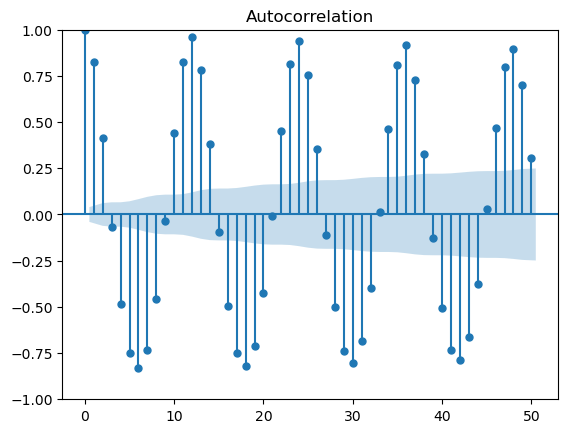

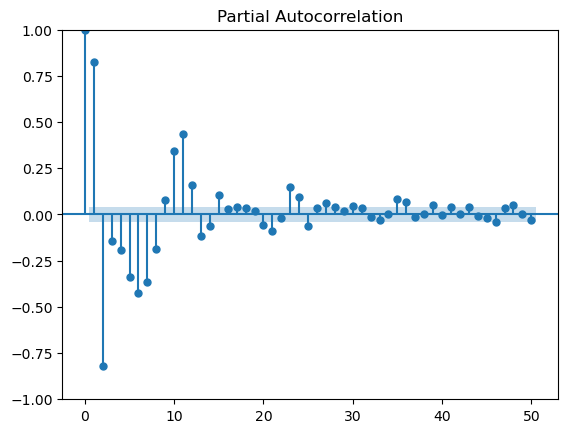

In [ ]:

plot_acf(city_df,lags = 50)
plot_pacf(city_df,lags = 50)
plt.show()

if (is_stationary==True):
    d = 0
else:
    d = 1

In [ ]:
#Comparing p,q values based on AIC and BIC score
p_range = q_range = list(range(0, 3))  

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            
            model = ARIMA(city_df['AverageTemperature'], order=(p, d, q))  
            results = model.fit()  
            aic_values.append(results.aic) 
            bic_values.append(results.bic)  
            pq_values.append((p, q))
        except Exception as e:
            print(f"Failed to fit ARIMA({p},{d},{q}): {e}")  
            continue  

if aic_values:
    best_pq = pq_values[aic_values.index(min(aic_values))]  
    print("(p,q) corresponding to lowest AIC score: ", best_pq)
else:
    print("No models were successfully fitted.")


(p,q) corresponding to lowest AIC score:  (2, 2)


In [ ]:
import plotly.graph_objects as go

# Create traces for actual and predicted values
fig = go.Figure()

# Add actual temperature trace with hover data
fig.add_trace(go.Scatter(
    y=list(city_df.AverageTemperature)[:100],
    mode='lines',
    name='Actual',
    line=dict(color='blue'),
    hovertemplate='Index: %{x}<br>Temperature: %{y:.2f}°C'
))

# Add predicted temperature trace with hover data
fig.add_trace(go.Scatter(
    y=list(predictions)[:100],
    mode='lines',
    name='Predicted',
    line=dict(color='red'),
    hovertemplate='Index: %{x}<br>Temperature: %{y:.2f}°C'
))

# Update layout with labels, title, and legend position
fig.update_layout(
    title='Actual and Predicted Temperature Values',
    xaxis=dict(
        title='Time (in Months)',
        rangeslider=dict(visible=True),  # Enable range slider for zooming
    ),
    yaxis=dict(title='Temperature (°C)'),
    legend=dict(
        title='Legend',
        x=1.05,  # Adjust horizontal position
        y=0.8    # Adjust vertical position
    ),
    width=1000,
    height=750,
    template='plotly_dark',  # Dark theme for aesthetic
    hovermode='closest'  # Display closest hover data point
)

# Add a button to toggle between actual and predicted temperature traces
fig.update_layout(
    updatemenus=[
        {
            'buttons': [
                {
                    'args': [None, {'visible': [True, False]}],
                    'label': 'Show Actual Only',
                    'method': 'relayout'
                },
                {
                    'args': [None, {'visible': [True, True]}],
                    'label': 'Show Both',
                    'method': 'relayout'
                },
                {
                    'args': [None, {'visible': [False, True]}],
                    'label': 'Show Predicted Only',
                    'method': 'relayout'
                }
            ],
            'direction': 'down',
            'pad': {'r': 10, 't': 10},
            'showactive': True,
            'x': 0.17,
            'xanchor': 'left',
            'y': 1.15,
            'yanchor': 'top'
        }
    ]
)

# Show the plot
fig.show()

In [ ]:

from sklearn.metrics import mean_absolute_error

arima_model = ARIMA(city_df, order=(best_pq[0], 0, best_pq[1])).fit()
predictions = arima_model.predict(start=0, end=len(city_df)-1)

mse = mean_squared_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Squared Error:", mse)

mae = mean_absolute_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Absolute Error:", mae)

Mean Squared Error: 3.7969332541281178
Mean Absolute Error: 1.5682643929642717


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Preprocessing for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(city_df["AverageTemperature"].values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)

# Reshape y to match the LSTM input
y = y.reshape(-1, 1)

# Split into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()

# LSTM layers with Dropout for regularization
model.add(LSTM(50, activation='tanh', input_shape=(sequence_length, 1), return_sequences=True))
model.add(Dropout(0.2))  # Add Dropout layer to reduce overfitting
model.add(LSTM(50, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))  # Add Dropout layer again
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with validation data and EarlyStopping
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

model.summary()

# Predictions
predictions = model.predict(X_test)

# Inverse transform the predicted and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)


Epoch 1/60
60/60 [==============================] - 5s 26ms/step - loss: 0.1179 - val_loss: 0.0813
Epoch 2/60
60/60 [==============================] - 1s 13ms/step - loss: 0.0680 - val_loss: 0.0522
Epoch 3/60
60/60 [==============================] - 1s 13ms/step - loss: 0.0172 - val_loss: 0.0189
Epoch 4/60
60/60 [==============================] - 1s 11ms/step - loss: 0.0161 - val_loss: 0.0186
Epoch 5/60
60/60 [==============================] - 1s 12ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 6/60
60/60 [==============================] - 1s 12ms/step - loss: 0.0129 - val_loss: 0.0097
Epoch 7/60
60/60 [==============================] - 1s 12ms/step - loss: 0.0117 - val_loss: 0.0081
Epoch 8/60
60/60 [==============================] - 1s 11ms/step - loss: 0.0103 - val_loss: 0.0117
Epoch 9/60
60/60 [==============================] - 1s 11ms/step - loss: 0.0105 - val_loss: 0.0129
Epoch 10/60
60/60 [==============================] - 1s 11ms/step - loss: 0.0094 - val_loss: 0.0170
Epoch 11/

In [ ]:
fig = go.Figure()

# Add actual temperature trace with hover data
fig.add_trace(go.Scatter(
    x=np.arange(len(y_test_actual)), y=y_test_actual.flatten(),
    mode='lines', name='Actual Temperature',
    line=dict(color='blue'),
    hovertemplate='Index: %{x}<br>Temperature: %{y:.2f}°C',
))

# Add predicted temperature trace with hover data
fig.add_trace(go.Scatter(
    x=np.arange(len(predictions)), y=predictions.flatten(),
    mode='lines', name='Predicted Temperature',
    line=dict(color='red'),
    hovertemplate='Index: %{x}<br>Temperature: %{y:.2f}°C',
))

# Update layout with labels, title, and legend position
fig.update_layout(
    title='Actual vs Predicted Temperature',
    xaxis=dict(title='Time (Index)', rangeslider=dict(visible=True)),
    yaxis=dict(title='Temperature (°C)'),
    legend=dict(
        title='Legend',
        x=1.05,  # Adjust horizontal position
        y=0.8    # Adjust vertical position
    ),
    width=1000,
    height=750,
    template='plotly_dark',  # Dark theme for a better aesthetic
    hovermode='closest'  # Display closest hover data point
)

# Add slider to zoom in on specific ranges in time
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
        showgrid=True,
        zeroline=False
    )
)

# Add a button to toggle between actual and predicted temperature traces
fig.update_layout(
    updatemenus=[
        {
            'buttons': [
                {
                    'args': [None, {'visible': [True, False]}],
                    'label': 'Show Actual Only',
                    'method': 'relayout'
                },
                {
                    'args': [None, {'visible': [True, True]}],
                    'label': 'Show Both',
                    'method': 'relayout'
                },
                {
                    'args': [None, {'visible': [False, True]}],
                    'label': 'Show Predicted Only',
                    'method': 'relayout'
                }
            ],
            'direction': 'down',
            'pad': {'r': 10, 't': 10},
            'showactive': True,
            'x': 0.17,
            'xanchor': 'left',
            'y': 1.15,
            'yanchor': 'top'
        }
    ]
)

# Show the plot
fig.show()

# Print some metrics to evaluate
mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 3.4047332685138003
Mean Absolute Error: 1.490303784240467


In [ ]:
#Select the no. of years
years_drop_down_menu = widgets.Dropdown(
    options=list(range(1,201)),
    value=10,
    description='No. of Years:',
    disabled=False,
)

years_drop_down_menu

Dropdown(description='No. of Years:', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

In [ ]:

num_years = years_drop_down_menu.value

last_month_in_dataset = city_df.index[-1].month 

remaining_months = 12 - last_month_in_dataset  

number_of_steps = remaining_months + num_years * 12  

forecast_result = arima_model.forecast(steps=number_of_steps)

out_of_sample_forecast = forecast_result

out_of_sample_forecast = out_of_sample_forecast[remaining_months:]

print(out_of_sample_forecast)


2398    18.826698
2399    21.393398
2400    24.818244
2401    28.101168
2402    30.349975
          ...    
2513    25.054598
2514    25.049521
2515    25.075226
2516    25.122531
2517    25.176951
Name: predicted_mean, Length: 120, dtype: float64


In [ ]:
# displaying forecasted values for the nth year

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
i = 0
for x in out_of_sample_forecast[-12:]:  # last year
    print(months[i]+": ", x, 'C')
    i += 1

January:  25.234340466216477 C
February:  25.28532890271554 C
March:  25.298450661438718 C
April:  25.272708789077644 C
May:  25.21785261148354 C
June:  25.150958964228614 C
July:  25.091235701263976 C
August:  25.05459764112069 C
September:  25.049520859553574 C
October:  25.075226293073282 C
November:  25.12253126132018 C
December:  25.17695119459792 C


In [ ]:
import plotly.graph_objects as go

# Assuming `out_of_sample_forecast` and `num_years` are already defined

# Create the trace for the predicted temperatures
trace = go.Scatter(
    x=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
    y=out_of_sample_forecast[-12:],  # Assuming this contains predictions for the last 12 months
    mode='lines',
    name='Average Temperature'
)

# Layout of the plot
layout = go.Layout(
    title=f'Predicted Temperatures for the Year {2014 + num_years}',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Temperature (°C)'),
    template="plotly_dark"  # Optional for dark theme
)

# Create the figure and display it
fig = go.Figure(data=[trace], layout=layout)
fig.show()  # Use fig.show() for interactive Plotly plots


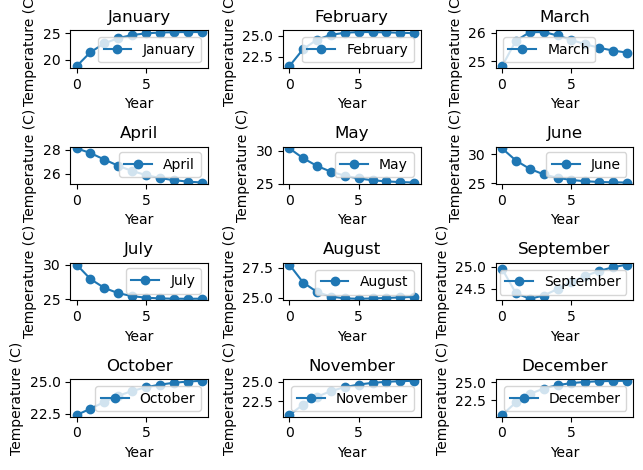

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3)

monthly_change = {}

for month in range(12):
    temp = month
    for year in range(num_years):
        if temp < len(out_of_sample_forecast):  
            if month not in monthly_change:
                monthly_change[month] = [out_of_sample_forecast.iloc[temp]]  
            else:
                monthly_change[month].append(out_of_sample_forecast.iloc[temp])  
            temp += 12  
        else:
            break  

# Plotting the data
for i, month in enumerate(monthly_change):
    ax[i//3, i%3].plot(monthly_change[month], marker='o', label=months[month])
    ax[i//3, i%3].set_title(months[month])
    ax[i//3, i%3].set_xlabel('Year')
    ax[i//3, i%3].set_ylabel('Temperature (C)')
    ax[i//3, i%3].legend()

plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming monthly_change and num_years are already defined

# List of months for labeling
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

# Create subplots (4 rows, 3 columns)
fig = make_subplots(
    rows=4, cols=3,
    subplot_titles=months,
    shared_xaxes=True,
    shared_yaxes=True
)

# Add traces for each month
for pos in range(12):
    fig.add_trace(
        go.Scatter(
            x=[2014 + i for i in range(num_years)],  # Years from 2014 to 2014 + n
            y=monthly_change[pos],
            mode='lines+markers',
            name=months[pos]
        ),
        row=(pos // 3) + 1,  # Determine row (1 to 4)
        col=(pos % 3) + 1   # Determine column (1 to 3)
    )

# Update layout for the plot
fig.update_layout(
    title="Monthly Temperature Changes from 2014 to 2014 + n years",
    showlegend=False,  # Hide legend as it's redundant here
    height=800,        # Set height of the figure
    width=1000,        # Set width of the figure
    template="plotly_dark",
    xaxis_title="Year",
    yaxis_title="Temperature (°C)"
)

# Show the interactive plot
fig.show()


When we forecasted the future temperature values for New York, we could infer from the above plots that the summers seem to be getting cooler and the winters seem to be getting warmer over the next decade.<br>
Objective 3 analyzes the factors that might possibly affect temperature change.

### OBJECTIVE 2: Top-10 Cities in the India with Maximum Temperature Change

In [ ]:

df = pd.read_csv("GlobalLandTemperaturesByCity.csv")

df['dt'] = pd.to_datetime(df['dt'])

df.index = df['dt']
del df['dt']
df = df.drop({"AverageTemperatureUncertainty"}, 1)
df = df.dropna()

new_us_cities_df = df[df.Country=='India'].drop('Country', 1)
new_us_cities_df['latlon'] = new_us_cities_df['Latitude'] + ', ' + new_us_cities_df['Longitude']
new_us_cities_df = new_us_cities_df.sort_values('latlon')
unique_latlon_values = set(list(new_us_cities_df.latlon))

cities = list(new_us_cities_df.City)

unique_latlon_first_cities = []

for x in unique_latlon_values:
    i = list(new_us_cities_df.latlon).index(x)
    unique_latlon_first_cities.append(cities[i])

part_2_df = df[df['City'].isin(unique_latlon_first_cities)].drop(['Country', 'Latitude', 'Longitude'], 1)
part_2_df.head()

,AverageTemperature,City
dt,,
1816-03-01,19.934,Abohar
1816-04-01,26.641,Abohar
1816-05-01,32.535,Abohar
1816-06-01,33.254,Abohar
1816-07-01,31.105,Abohar


In [ ]:
from joblib import Parallel, delayed

def process_city(each_city, part_2_df):
    changes = []  
    avg_2013 = None  
    avg_2023 = None  

    new_city_df = part_2_df[part_2_df.City == each_city].drop("City", 1)  
    new_city_df_mean = new_city_df.resample("A").mean()  
    new_city_df_mean = new_city_df_mean.dropna()

    if new_city_df_mean.empty:
        return None, None, None
    
    last_year_average = new_city_df_mean['AverageTemperature'][-1]  
    avg_2013 = last_year_average
    
    
    p_range = q_range = [i for i in range(0, 2)]  

    aic_values = []
    bic_values = []
    pq_values = []

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(new_city_df, order=(p, 0, q))
                results = model.fit()  
                aic_values.append(results.aic)  
                bic_values.append(results.bic)  
                pq_values.append((p, q))
            except Exception as e:
                print(f"Error fitting ARIMA for {each_city} with p={p}, q={q}: {e}")
                pass
    
    if aic_values:  
        best_pq = pq_values[aic_values.index(min(aic_values))]  
        arima_model = ARIMA(new_city_df, order=(best_pq[0], 0, best_pq[1])).fit()
        
        out_of_sample_forecast = arima_model.forecast(steps=120)  
        
        if len(out_of_sample_forecast) > 0:
            average_after_10_years = np.mean(out_of_sample_forecast[-9:])  
            avg_2023 = average_after_10_years
            
            return each_city, abs(last_year_average - average_after_10_years), avg_2013, avg_2023
    return each_city, None, avg_2013, avg_2023

results = Parallel(n_jobs=-1)(delayed(process_city)(each_city, part_2_df) for each_city in set(unique_latlon_first_cities))

valid_results = [result for result in results if result[1] is not None]
changes, cities, avg_2013_list, avg_2023_list = zip(*[(res[1], res[0], res[2], res[3]) for res in valid_results])

top_10_changes_indices = np.argsort(changes)[::-1][:10]
top_10_cities = [cities[i] for i in top_10_changes_indices]
top_10_avg_2013 = [avg_2013_list[i] for i in top_10_changes_indices]
top_10_avg_2023 = [avg_2023_list[i] for i in top_10_changes_indices]

top10_df = pd.DataFrame({
    'city': top_10_cities,
    'latitude': [new_us_cities_df[new_us_cities_df.City == x]['Latitude'].iloc[-1] if not new_us_cities_df[new_us_cities_df.City == x].empty else None for x in top_10_cities],
    'longitude': [new_us_cities_df[new_us_cities_df.City == x]['Longitude'].iloc[-1] if not new_us_cities_df[new_us_cities_df.City == x].empty else None for x in top_10_cities],
    '2013_average': top_10_avg_2013,
    '2023_average': top_10_avg_2023
})

print(top10_df)



                city latitude longitude  2013_average  2023_average
0          Proddatur   15.27N    79.17E     30.095875     27.942557
1              Selam   12.05N    78.90E     29.361875     27.278527
2              Kolar   13.66N    78.44E     28.188750     26.115418
3        Dharmavaram   15.27N    77.50E     29.313375     27.254801
4              Hisar   29.74N    75.69E     26.505500     24.490794
5           Tirupati   13.66N    80.09E     30.411750     28.417130
6        Mahbubnagar   16.87N    78.70E     28.851250     26.864267
7             Abohar   29.74N    73.85E     26.718000     24.752850
8  Tiruchchirappalli   10.45N    79.36E     29.930625     28.008797
9           Srinagar   34.56N    73.95E     11.639750      9.732418


### OBJECTIVE 3: The Effect of Pollution and Greenhouse Gases on Temperature Change For United States 
For the sake of simplicity, we have only considered the effect of pollution and Greenhouse Gases on temperature change in New York from 2013-2023.
#### SECTION 1: Pollution and Temperature Change
Source of Pollution Data: <a href="https://www.kaggle.com/sogun3/uspollution/data" target="_blank">U.S. Pollution Data</a> from Kaggle.

In [ ]:
df = pd.read_csv('pollution.csv')
new_df = df.drop(['Unnamed: 0','State Code', 'County Code', 'Site Num', 'Address',
       'State', 'County', 'NO2 Units', 'NO2 Mean',
       'NO2 1st Max Value', 'NO2 1st Max Hour', 'O3 Units',
       'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'SO2 Units',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour','CO Units', 'CO Mean','CO 1st Max Value', 'CO 1st Max Hour'],axis = 1)

x= df['County']

In [ ]:
# For NO2
no2_df = new_df.drop(['O3 AQI', 'SO2 AQI', 'CO AQI'], axis="columns")
no2_df = no2_df.sort_values('NO2 AQI', ascending=False).drop_duplicates(subset='Date Local', keep='first')

# Convert Date Local to datetime format
no2_df['Date Local'] = pd.to_datetime(no2_df['Date Local'])
no2_df.index = no2_df['Date Local']
del no2_df['Date Local']

# Consider only New York City
no2_df = no2_df[no2_df['City'] == 'New York']

# Calculate mean NO2 AQI per year
no2_df = no2_df.resample("A").mean()
no2_df = no2_df.sort_index()
no2_df = no2_df.dropna()

#-----------------------------------------------------------------------------------------------------------------#

# For SO2
so2_df = new_df.drop(['O3 AQI', 'NO2 AQI', 'CO AQI'], axis="columns")
so2_df = so2_df.sort_values('SO2 AQI', ascending=False).drop_duplicates(subset='Date Local', keep='first')

# Convert Date Local to datetime format
so2_df['Date Local'] = pd.to_datetime(so2_df['Date Local'])
so2_df.index = so2_df['Date Local']
del so2_df['Date Local']

# Consider only New York City
so2_df = so2_df[so2_df['City'] == 'New York']

# Calculate mean SO2 AQI per year
so2_df = so2_df.resample("A").mean()
so2_df = so2_df.sort_index()
so2_df = so2_df.dropna()

#-----------------------------------------------------------------------------------------------------------------#

# For CO
co_df = new_df.drop(['SO2 AQI', 'NO2 AQI', 'O3 AQI'], axis="columns")
co_df = co_df.sort_values('CO AQI', ascending=False).drop_duplicates(subset='Date Local', keep='first')

# Convert Date Local to datetime format
co_df['Date Local'] = pd.to_datetime(co_df['Date Local'])
co_df.index = co_df['Date Local']
del co_df['Date Local']

# Consider only New York City
co_df = co_df[co_df['City'] == 'New York']

# Calculate mean CO AQI per year
co_df = co_df.resample("A").mean()
co_df = co_df.sort_index()
co_df = co_df.dropna()


In [ ]:
# Data Cleaning for Temperature Data where we are only considering the Temperature for New York City
df = pd.read_csv("GlobalLandTemperaturesByCity.csv")
df = df[df['Country'] == 'India']
df = df[df['City'] == 'New Delhi']
df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)

# Convert the Date Local column to date time format
df['Date Local'] = pd.to_datetime(df['dt'])
# set first column (dt) as the index column
df.index = df['Date Local']
del df['dt'],df['City'],df['Country']
df.dropna()

# As we have only one value per day we dont need to drop duplicates so this will calculate the Annual Mean Temperature
df = df.resample("A").mean()

df = df.dropna()
df = df.sort_index()

In [ ]:
# Joining different Pollution Data with the Temperature Data

j1 = pd.merge(df, no2_df, left_index = True, right_index = True, how='inner')
j2 = pd.merge(so2_df, j1, left_index = True, right_index = True, how='inner')
j3 = pd.merge(co_df, j2, left_index = True, right_index = True, how='inner')
j3.head()

,CO AQI,SO2 AQI,AverageTemperature,NO2 AQI
Date Local,,,,
2000-12-31,30.250000,62.476190,26.048333,70.000000
2001-12-31,19.000000,61.285714,25.862917,75.735294
2002-12-31,17.625000,59.342105,26.634333,71.692308
2003-12-31,19.357143,59.388889,25.721083,66.148148
2004-12-31,15.538462,53.675676,26.239917,64.921053


In [ ]:
# Normalize the data so that all the column data can be compared
j3_norm = (j3 - j3.mean()) / (j3.max() - j3.min())
j3_norm.head()

,CO AQI,SO2 AQI,AverageTemperature,NO2 AQI
Date Local,,,,
2000-12-31,0.654585,0.357917,-0.068485,0.347543
2001-12-31,0.132401,0.329215,-0.240207,0.575799
2002-12-31,0.068578,0.282354,0.474233,0.414894
2003-12-31,0.148978,0.283482,-0.371564,0.194245
2004-12-31,-0.028272,0.145735,0.108948,0.145408


In [ ]:
# Plotting the data
trace0 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['AverageTemperature'],
    mode = 'lines',
    name = 'Temperature'
)

trace1 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['CO AQI'],
    mode = 'lines',
    name = 'Carbon Monoxide'
)

trace3 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['SO2 AQI'],
    mode = 'lines',
    name = 'Sulphur Dioxide'
)

trace4 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['NO2 AQI'],
    mode = 'lines',
    name = 'Nitrogen Dioxide'
)

layout = go.Layout(
    title='Temperature and Pollution Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace3,trace4]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

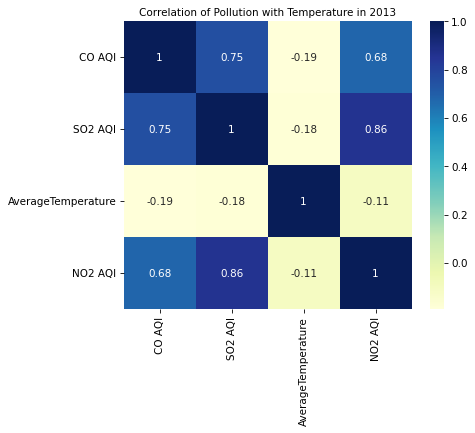

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure there are no NaN values
j3_norm = j3_norm.dropna()

# Plotting the correlation matrix for Pollution vs. Temperature
fig = plt.figure(dpi=75)

# Create axis for heatmap
ax = fig.add_axes([0.1, 0.1, 0.75, 0.8])

# Create the heatmap
sns.heatmap(j3_norm.corr(method='pearson'), annot=True, cmap="YlGnBu", ax=ax)

# Title for the plot
ax.set_title("Correlation of Pollution with Temperature in 2013", fontsize=10)

# Display the plot
plt.show()


#### SECTION 2: Greenhouse Gases and Temperature Change
Source of Greenhouse Gases data: <a href="https://www.kaggle.com/unitednations/international-greenhouse-gas-emissions" target="_blank">International Greenhouse Gas Emissions</a> from Kaggle.

In [ ]:
df = pd.read_csv("GlobalLandTemperaturesByCity.csv")

# convert first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# set first column (dt) as the index column
df.index = df['dt']
del df['dt']

df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude","Country"}, 1)

df = df.dropna()

df = df[df['City']=='New York']
df = df.drop({'City'},1)
df = df.resample("A").mean()
df.head(10)

,AverageTemperature
dt,
1743-12-31,3.264000
1744-12-31,11.660375
1745-12-31,1.134500
1746-12-31,NaN
1747-12-31,NaN
1748-12-31,NaN
1749-12-31,NaN
1750-12-31,10.071455
1751-12-31,10.794625


In [ ]:
gg_df = pd.read_csv("greenhouse_gas_inventory_data_data.csv")

df_usa = gg_df[gg_df['country_or_area']=='United States of America'].drop('country_or_area', 1)

# getting yearly emissions for the 4 major greenhouse gases i.e. CO2, Methane, Nitrous Oxide and HCFCs
df_usa_co2 = df_usa[df_usa['category']=='carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_co2 = df_usa_co2.sort_values('year')
df_usa_co2.columns=['year','co2']

df_usa_methane = df_usa[df_usa['category']=='methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_methane = df_usa_methane.sort_values('year')
df_usa_methane.columns=['year','methane']

df_usa_n2o = df_usa[df_usa['category']=='nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_n2o = df_usa_n2o.sort_values('year')
df_usa_n2o.columns=['year','n2o']

df_usa_hcfc = df_usa[df_usa['category']=='hydrofluorocarbons_hfcs_emissions_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_hcfc = df_usa_hcfc.sort_values('year')
df_usa_hcfc.columns=['year','hcfc']

# Set Index
df_usa_co2.index = df_usa_co2['year']
df_usa_methane.index = df_usa_methane['year']
df_usa_n2o.index = df_usa_n2o['year']
df_usa_hcfc.index = df_usa_hcfc['year']

del df_usa_co2['year'],df_usa_methane['year'],df_usa_n2o['year'],df_usa_hcfc['year']



In [ ]:
co2 = df_usa_co2['co2']
n2o = df_usa_n2o['n2o']
methane = df_usa_methane['methane']
hcfc = df_usa_hcfc['hcfc']
temp = list(df['AverageTemperature'])[-25:]

part3 = pd.DataFrame({'co2':co2,'n2o':n2o,'methane':methane,'hcfc':hcfc,'temp': temp},columns = ['co2','n2o','methane','hcfc','temp'])
part3.head()

,co2,n2o,methane,hcfc,temp
year,,,,,
1990,5.115095e+06,406228.526626,773854.896420,46288.814184,9.661333
1991,5.064880e+06,396113.656867,777034.220915,41618.413588,11.322500
1992,5.170274e+06,404052.107073,776869.789752,47427.662176,11.357250
1993,5.284759e+06,420503.190940,764089.671267,47500.262267,9.572667
1994,5.377492e+06,402478.930460,770450.426146,53246.654974,10.040917


In [ ]:
# normalizing the values

part3_norm = (part3 - part3.mean()) / (part3.max() - part3.min())

In [ ]:
# Plotting values for Greenhouse Gases along with Temperature

trace0 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['temp'],
    mode = 'lines',
    name = 'Temperature'
)

trace1 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['co2'],
    mode = 'lines',
    name = 'Carbon Dioxide'
)

trace2 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['n2o'],
    mode = 'lines',
    name = 'Nitrous Oxide'
)

trace3 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['methane'],
    mode = 'lines',
    name = 'Methane'
)

trace4 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['hcfc'],
    mode = 'lines',
    name = 'Hydrofluorocarbon'
)


layout = go.Layout(
    title='Temperature and Greenhouse Gases Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace2,trace3,trace4]
fig = go.Figure(data=data, layout=layout)
iplot(fig)


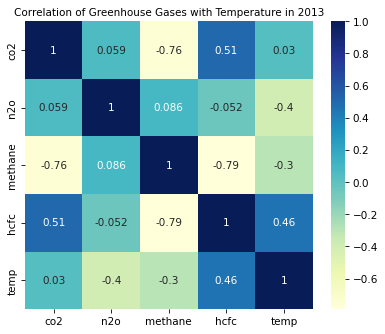

In [ ]:
# Plotting the correlation matrix for the Greenhouse Gases

fig = plt.figure(dpi = 75)

ax = fig.add_axes([0.1, 0.1, 0.75, 0.8]) 
sns.heatmap(part3.corr(method='pearson'), annot = True, cmap="YlGnBu")
ax.set_title("Correlation of Greenhouse Gases with Temperature in 2013", fontsize=10)
plt.show()

From the above correlation matrix, we can infer that HCFCs (HydroChloroFluoroCarbons) have the most impact on temperature.<br>
We now predict the future Greenhouse Gas emissions and their impact on future temperature values from 2013-2023.

From the above correlation matrix, we can infer that HCFCs (HydroChloroFluoroCarbons) will still have the highest impact on temperature.<br>Steps must be taken to reduce the emission of HCFCs to reduce their impact on temperature.

##
The heatmap visualizes the correlation between greenhouse gases (Methane, CO2, HCFC) and temperature predictions using ARIMA and LSTM models. Correlation values range from -1 (strong negative correlation) to 1 (strong positive correlation). Based on the heatmap:

### Key Observations:
1. **Methane_ARIMA**:
   - Strong positive correlation with `Temperature_ARIMA` (0.65).
   - Negative correlation with `Temperature_LSTM` (-0.6).
   - Suggests that ARIMA predicts Methane to significantly affect temperature positively, while LSTM does not agree as strongly.

2. **CO2_ARIMA**:
   - Moderate negative correlation with both `Temperature_ARIMA` (-0.52) and `Temperature_LSTM` (-0.87).
   - Indicates CO2's inverse relationship with temperature, according to both models, though LSTM suggests a stronger effect.

3. **HCFC_ARIMA**:
   - High positive correlation with `Temperature_ARIMA` (0.71) and moderate positive correlation with `Temperature_LSTM` (0.63).
   - Highlights that HCFC emissions might have a positive relationship with temperature rise.

4. **Methane_LSTM**:
   - Moderate negative correlation with `Temperature_ARIMA` (-0.28) and strong positive correlation with `Temperature_LSTM` (0.92).
   - Suggests differing predictions by ARIMA and LSTM, with LSTM emphasizing a significant positive effect of methane on temperature.

5. **CO2_LSTM**:
   - Negative correlation with `Temperature_ARIMA` (-0.33) and strong positive correlation with `Temperature_LSTM` (0.89).
   - Indicates that LSTM highlights CO2 as a significant contributor to temperature, contrary to ARIMA.

6. **HCFC_LSTM**:
   - Negative correlation with `Temperature_ARIMA` (-0.37) and strong positive correlation with `Temperature_LSTM` (0.87).
   - Suggests that LSTM identifies HCFC as a major positive contributor to temperature changes, unlike ARIMA.

7. **Temperature Predictions**:
   - Correlation between `Temperature_ARIMA` and `Temperature_LSTM` is low (0.097).
   - Implies that ARIMA and LSTM produce different temperature forecasts, potentially due to their model structures.

### Conclusions:
- ARIMA and LSTM models show discrepancies in predicting the relationships between greenhouse gases and temperature, with LSTM generally highlighting stronger positive correlations.
- HCFC is identified as having the most consistent positive correlation with temperature across models.
- Methane and CO2 correlations vary significantly between models, which warrants further investigation to reconcile these differences.
- The low agreement between ARIMA and LSTM temperature predictions suggests the need for further model tuning or hybrid approaches for better forecasting accuracy.


### In this project, we:

<ul>
<li>Forecasted the temperature of a given city over a given period of time</li>
<li>Predicted the top-10 cities in the India which will experience the most temperature change from 2013-2023.</li>
<li>Analyzed the correlation between pollution levels and temperature, as well as the correlation between Greenhouse gas emissions and temperature, which helped us identify the Greenhouse Gas that has and will have the most impact on temperature change.</li>
</ul>